# Classifying trialwise CorrectGo and NoGo trials

There are a number of steps to this. Hopefully we can recycle previous code and be up fairly quickly!

1. Load beta data. Ideally this process should include a cache into a pure python object so we don't have to reload it each time.
2. Preprocess the data.
3. Do cross-validated training and testing. Ideally an inner loop to select best parameters, an outer loop to get cross-validated performance, and final training over all the data to get an image. The inner loop can be probably be handled within the package we use probably.

In [1]:
import socket
import yaml
hostname=socket.gethostname()
hostname='zzz'
with open('sst_config.yml', "r") as f:
    test_config= yaml.safe_load(f)#[hostname]

In [2]:
import sys
import os
import pandas as pd
import numpy as np



sys.path.append(os.path.abspath("../../ml/"))
from apply_loocv_and_save import load_and_preprocess
from dev_utils import read_yaml_for_host
from dev_utils import get_2DX_from_4DX
import warnings


config_data = read_yaml_for_host("sst_config.yml")



python initialized for apply_loocv_and_save
cpus available; cpus to use:
10 9
10


In [3]:
import multiprocessing
import math
import nibabel as nib
import nilearn as nl
from nilearn.decoding import DecoderRegressor,Decoder
from sklearn.model_selection import KFold,GroupKFold,LeaveOneOut
cpus_available = multiprocessing.cpu_count()

cpus_to_use = min(cpus_available-1,math.floor(0.9*cpus_available))
print(cpus_to_use)

9


In [4]:
from dev_wtp_io_utils import cv_train_test_sets, asizeof_fmt
from nilearn.decoding import DecoderRegressor,Decoder

In [5]:
nonbids_data_path = config_data['nonbids_data_path']
ml_data_folderpath = nonbids_data_path + "fMRI/ml"


## Set up the paradigm

In [6]:

def trialtype_resp_trans_func(X):
    return(X.trial_type)


## Loading beta data

beta data is generally written in `load_multisubject_brain_data_sst_w1.ipynb`.

We just have to load it.

In [7]:
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_30subs_correct_cond_pfc.pkl'
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_6subs_correct_cond.pkl'
warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20220818T144138.csv"

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34507/2753699166.py:3: UserWarning: not sure if this file holds up--it was created in 2021; need to see if it's still valid
  warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")


In [8]:


all_subjects = load_and_preprocess(
    brain_data_filepath,
    train_test_markers_filepath,
    subjs_to_use = None,
    response_transform_func = trialtype_resp_trans_func,
    clean=None)

warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


checked for intersection and no intersection between the brain data and the subjects was found.
there were 6 subjects overlapping between the subjects marked for train data and the training dump file itself.


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


test_train_set: 62918
brain_data_filepath: 168
pkl_file: 168
train_test_markers_filepath: 158
response_transform_func: 144
sys: 72
Brain_Data_allsubs: 48
clean: 16
subjs_to_use: 16


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


601
601
cleaning memory


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34507/1474138623.py:8: UserWarning: the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.
  warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


In [9]:
from sklearn.feature_selection import SelectPercentile,f_classif

#convert the y array to an integer array representing the string values of the y array
all_subjects['y_cat'] = all_subjects['y'].astype('category')
all_subjects['y_int']=all_subjects['y_cat'].cat.codes

# #get the X fdata
# x_fdata = all_subjects['X'].get_fdata()
# print(x_fdata.shape)
# #flatten first 3 dims of X fdata to a single dim
# x_fdata_1d = x_fdata.reshape([np.prod(x_fdata.shape[0:3]), x_fdata.shape[3]])
# print(x_fdata_1d.shape)



# #SelectPercentile(f_classif,percentile=5).fit_transform(,all_subjects['y_int'])

In [10]:
mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [11]:
num_subjs = 6
if num_subjs<len(all_subjects['metadata']['subject'].unique()):
    #cut down to just 9 subjects
    selected_subjs={}
    print(all_subjects.keys())

    #select subjs
    subjs = all_subjects['metadata']['subject'].unique()
    subjs.sort()
    selected_sub_ids=subjs[0:num_subjs]
    #get index of selected subjs
    selected_subjs_idx_bool = all_subjects['metadata']['subject'].isin(selected_sub_ids)
    #get list of True indices
    selected_subjs_idx = selected_subjs_idx_bool[selected_subjs_idx_bool].index.tolist()

    subjs = all_subjects['metadata']['subject'].unique()
    selected_subjs['X'] = nib.funcs.concat_images([all_subjects['X'].slicer[...,s] for s in selected_subjs_idx])
    selected_subjs['y'] = all_subjects['y'][selected_subjs_idx_bool]

    selected_subjs['y'] = all_subjects['y'][selected_subjs_idx_bool]
    selected_subjs['groups'] = all_subjects['groups'][selected_subjs_idx_bool]
    selected_subjs['metadata'] = all_subjects['metadata'][selected_subjs_idx_bool]
else:
    selected_subjs = all_subjects

In [12]:
# get the PFC mask
mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [13]:
#convert the y array to an integer array representing the string values of the y array
selected_subjs['y_cat'] = selected_subjs['y'].astype('category')
selected_subjs['y_int']=selected_subjs['y_cat'].cat.codes

In [14]:
X=selected_subjs['X']

In [15]:

def get_2DX_from_4DX(nifti_X):

    if len(nifti_X.shape)==3:
        #add an extra dimension to the mask fdata
        nifti_X = np.expand_dims(nifti_X,axis=3)
        
    #rotate my array so that the last dimension is first
    #print(nifti_X.shape)
    nifti_X=np.moveaxis(nifti_X,-1,0)
    #print(nifti_X.shape)
    pre_reshaped_shape = nifti_X.shape
    #now flatten dims 2-4 into a single dimension
    arr2d_full=nifti_X.reshape([nifti_X.shape[0],np.prod(nifti_X.shape[1:4])])
    #print("this is the form of the data that the decoder wants, (n_samples, n_features)")
    #print(arr2d_full.shape)
    return(arr2d_full)


def get_4DX_from_2DX(arr2d,pre_reshaped_shape):
    #now undo the above operations to get the original matrix
    arr4d=arr2d.reshape(pre_reshaped_shape)
    #print(arr4d.shape)
    arr4d=np.moveaxis(arr4d,0,-1)
    #print(arr4d.shape)
    return(arr4d)

Transform our mask into the same space as the data


In [16]:
X.slicer[:,:,:,0].shape

(97, 115, 97)

In [17]:
external_mask = mask_nifti
external_mask_resampled = nl.image.resample_to_img(external_mask, X.slicer[:,:,:,0],interpolation='nearest')
external_mask_bin = nl.image.math_img("(np.round(img,3)>0.1).astype(int)",img=external_mask_resampled)


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


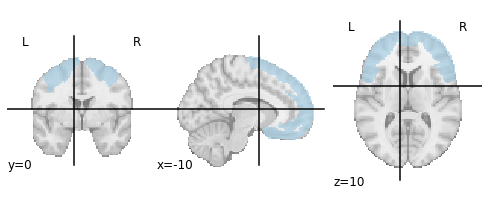

In [18]:
#view the mask
nl.plotting.plot_roi(external_mask_bin,display_mode='ortho',cut_coords=[-10,0,10],cmap='Paired')

Looks great!

In [19]:
# def apply_mask_in_2d(X_2d,mask_2d):
#     #apply the mask to the 2d samples
#     masked_2d_samples = X_2d[:,mask_2d]
#     return(masked_2d_samples)

mask_2d = get_2DX_from_4DX(external_mask_bin.get_fdata())
X_2d=get_2DX_from_4DX(X.get_fdata())
#repeat the mask for each sample
# mask_2d_rep = np.repeat(mask_2d.astype(bool),X_2d.shape[0],axis=0)
# print(mask_2d_rep.shape)
# print(X_2d.shape)
# X_2d_masked = X_2d[mask_2d_rep]
print(sum(mask_2d[0].astype(bool)))

43899


In [20]:
#iterate through first dimension of X_2d numpy array and apply mask to each sample
X_2d_masked = np.apply_along_axis(lambda sample: sample[mask_2d[0].astype(bool)],1,X_2d)
print(X_2d_masked.shape)

(601, 43899)


# Training

I'm going to start with `cv_train_test_sets` and see how that goes. It sems likely it'll have to be re-written somewhat, but it might be a good starting point.

I think I need to run this without all the extra scaffolding--just tresting the Decoder on the data until I get something sensible. At the very least we need to know the Decoder object is handling balanced classes correctly.

In [21]:
# use add PFC mask.ipynb to figure out how to get a PFC mask onto this data.

In [22]:
from EstimatorWithPreprocessing import EstimatorWithPreprocessor
#import SVC
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SequentialFeatureSelector, SelectKBest


In [23]:
k_fit = SelectKBest(f_classif, k=100).fit(X_2d_masked,y=np.array(selected_subjs['y_int']))

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   42    86   103 ... 43883 43890 43891] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [35]:
ewp = EstimatorWithPreprocessor(
    estimator=LinearSVC(penalty='l2',max_iter=1e4),
    preprocessor= k_fit
)

In [36]:
ewp.cv_scores_

In [ ]:
#alternative to cv_train_test_sets

# a function to do a group k-fold cross-validation
# do a group k-fold to estimate *performance*
# within each group, 
# do an inner cross-validation
# go through each candidate estimator and do a gridsearch to find the best parameters for that estimator
# record the results from the cumulative inner-CV for each estimator and parameter combination
# identify the best estimator/parameter combination
# then, do a group k-fold to estimate *performance/generalization* of the best estimator/parameter combination

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneGroupOut

def cross_validate(X, y, estimator_set, groups=None, scoring=None, cv=None, n_jobs=None,
    verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False,
    return_estimator=False, return_times=False, error_score=np.nan
):
    """Evaluate metric(s) by cross-validation and also record fit/score times.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be, for example a list, or an array at least 2d.
    y : array-like of shape (n_samples,) or (n_samples, n_outputs), default=None
        The target variable to try to predict in the case of
        supervised learning.
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set.
    scoring : str, callable, list/tuple or dict, default=None
        A single str (see :ref:`scoring_parameter`) or a callable
        (see :ref:`scoring`) to evaluate the predictions on the test set.
        For evaluating multiple metrics, either give a list of (unique) strings
        or a dict with names as keys and callables as values.
        NOTE that when using custom scorers, each scorer should return a single
        value. Metric functions returning a list/array of values can be wrapped
        into multiple scorers that return one value each.
        See :ref:`multimetric_grid_search` for an example.
        If None, the estimator's default scorer (if available) is used.
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
        - None, to use the default 5-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`Stratified
)
"""


In [55]:

def cross_validate(X, y, estimator_set, groups=None):
    # a function to do a group k-fold cross-validation
    # do a group k-fold to estimate *performance*
    # within each group, 
    # do an inner cross-validation
    # go through each candidate estimator and do a gridsearch to find the best parameters for that estimator
    # record the results from the cumulative inner-CV for each estimator and parameter combination
    # identify the best estimator/parameter combination
    # then, do a group k-fold to estimate *performance/generalization* of the best estimator/parameter combination

    from sklearn.metrics import roc_auc_score


    estimator_performance_df =pd.DataFrame(columns=['outer_fold_i','inner_fold_j','estimator_i','score'])

    outer_cv = GroupKFold(n_splits=3)
    inner_cv = GroupKFold(n_splits=3)

    outer_cv_split=outer_cv.split(X,groups=groups)

    for i, (train_i,validate_i) in enumerate(outer_cv_split):
        print("generalization test group " + str(i))
        
        print(len(train_i))
        print(len(validate_i))


        #now do inner CV
        for j, (train_j,validate_j) in enumerate(inner_cv.split(X[train_i],groups=groups[train_i])):
            print("hyper-parameter search group " + str(j))
        
            print(len(train_j))
            print(len(validate_j))
            #do a grid search using  to find the best parameters for each estimator

            for estimator_i, estimator in enumerate(estimator_set):
                #for now, don't implement the gridsearch because we don't need it; 
                # I just want to comapre the performance of the different estimators
                estimator.fit(X[train_i][train_j],y=np.array(selected_subjs['y_int'])[train_i][train_j])
                #now, evaluate the performance of the estimator on the validation set
                inner_y_pred = estimator.predict(X[train_i][validate_j])
                # get the score of the estimator on the test data
                inner_score = roc_auc_score(y[train_i][validate_j], inner_y_pred)
                #print the score for this estimator
                print("estimator " + str(estimator_i) + "; score: " + str(inner_score))
                #add an entry to the dataframe
                estimator_performance_df.loc[len(estimator_performance_df)] = [i,j,estimator_i,inner_score]

    #now, we have a list of lists of lists of scores for each estimator
    #we can select the best estimator for each fold from the estimators df
    #then, we can do a group k-fold to estimate *performance/generalization* of the best estimator/parameter combination
    overall_est_performance = estimator_performance_df.groupby(['estimator_i']).mean().sort_values(by='score',ascending=False,inplace=False)
    top_est_i = overall_est_performance['estimator_i'][0]
    print(top_est_i)
    #now we can do a group k-fold to estimate *performance/generalization* of the best estimator/parameter combination
    best_estimator = estimators[top_est_i]
    outer_y_pred = np.zeros(len(y))
    for i, (train_i,validate_i) in enumerate(outer_cv_split):
        best_estimator.fit(X_2d_masked[train_i],y=np.array(y)[train_i])
        #now, evaluate the performance of the estimator on the validation set
        outer_y_pred[validate_i] = best_estimator.predict(X_2d_masked[validate_i])
        # get the score of the estimator on the test data
        #outer_score = roc_auc_score(selected_subjs['y_int'][validate_i], outer_y_pred)

    # get the score of the estimator on the test data
    outer_score = roc_auc_score(y, outer_y_pred)

        
            

            
            

        

        


In [38]:
#dec_main = Decoder(standardize=True,cv=GroupKFold(3),scoring='roc_auc',n_jobs=cpus_to_use,mask=mask_nifti)
cv_results = cv_train_test_sets(
    trainset_X = X_2d_masked,
    trainset_y = selected_subjs['y_int'],
    trainset_groups = selected_subjs['metadata']['subject'],
    decoders = [ewp],
    cv=KFold(n_splits=3) # we use KFold, not GroupKfold, because it's splitting on Group anyway
    )

Groups are the same.
fold 1 of 3
In order to test on a training group of 4 items, holding out the following subjects:['DEV012' 'DEV006']. prepping fold data.... fitting.... 132.6 MiB. trying decoder 1 of 1. unable to use 'groups' passed to this item.


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   42    86   103 ... 43883 43890 43891] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AttributeError: 'LinearSVC' object has no attribute 'cv_scores_'

In [ ]:
#dec_main = Decoder(standardize=True,cv=GroupKFold(3),scoring='roc_auc',n_jobs=cpus_to_use,mask=mask_nifti)
cv_results = cv_train_test_sets(
    trainset_X = selected_subjs['X'],
    trainset_y = selected_subjs['y_int'],
    trainset_groups = selected_subjs['metadata']['subject'],
    decoders = [ewp],
    cv=KFold(n_splits=3) # we use KFold, not GroupKfold, because it's splitting on Group anyway
    )

Groups are the same.
fold 1 of 3
In order to test on a training group of 4 items, holding out the following subjects:['DEV011' 'DEV006']. prepping fold data.... fitting.... 3.1 GiB. trying decoder 1 of 1. 

ValueError: Expected 2D array, got scalar array instead:
array=<class 'nibabel.nifti1.Nifti1Image'>
data shape (97, 115, 97, 383)
affine: 
[[   2.    0.    0.  -96.]
 [   0.    2.    0. -132.]
 [   0.    0.    2.  -78.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  97 115  97 383   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -96.0
qoffset_y       : -132.0
qoffset_z       : -78.0
srow_x          : [  2.   0.   0. -96.]
srow_y          : [   0.    2.    0. -132.]
srow_z          : [  0.   0.   2. -78.]
intent_name     : b''
magic           : b'n+1'.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
cv_results_dict = {
    'test_scores':cv_results[0],
    'results':cv_results[1],
    'results_by_trainset_item':cv_results[2],
}

In [ ]:
cv_results_dict['results_by_trainset_item']

The following is derived from 3-fold cross-validation, and should indicate train/test performance classifying trials across subjects.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
#get precision and recall
print(precision_recall_fscore_support(
    cv_results_dict['results_by_trainset_item']['y'],
cv_results_dict['results_by_trainset_item']['y_pred'].astype(int),average='macro'))

#get roc_auc
from sklearn.metrics import roc_auc_score
print(roc_auc_score(
    cv_results_dict['results_by_trainset_item']['y'],
    cv_results_dict['results_by_trainset_item']['y_pred']))